<a href="https://colab.research.google.com/github/computational-neurology/workshop2025/blob/main/01_fMRI_and_neuropsychiatry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to fMRI, neuroanatomy and neuropsychiatry


### Let's compute functional connectivity!

Nilearn is a Python toolbox that has a built in function for extracting timeseries from functional files and doing all the extra signal processing at the same time. Let's walk through how this is done.

First we'll grab our imports to have all function that we need.

In [1]:
#! pip install numpy
#! pip install matplotlib
#! pip install pandas
!pip install nilearn
#! pip install bids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 37.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import image
from nilearn import datasets
from nilearn import plotting

Let's grab the data that we want to perform our connectivity analysis later on. Let’s define the regions we want to extract the signal from. We will use the Harvard-Oxford atlas.

In [3]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/fsl

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[uncompress_file] Extracting data from /root/nilearn_data/fsl/5c734f16e50cc772ef593cab9bb3137b/HarvardOxford.tgz...

[uncompress_file] .. done.

Let's have a look at the brain parcellation.

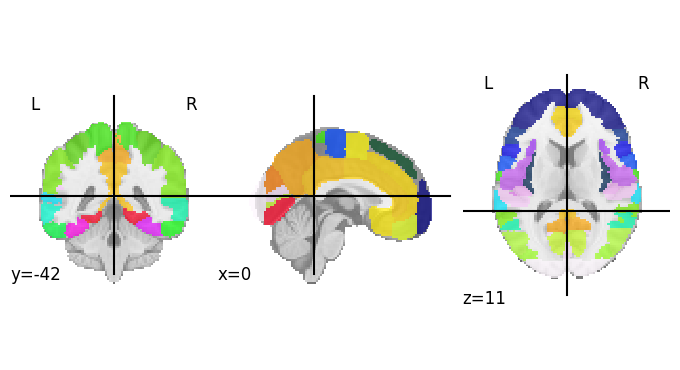

In [4]:
plotting.plot_roi(atlas_filename)

Let's now look at the names of the first ten brain regions of the parcellation.

In [29]:
# Load labels for each atlas region
labels
len(labels)

49

We can also look at the fMRI data from the dataset. Let's have a look at the different files associated with the fMRI data.

In [6]:
# One subject of fmri data
data = datasets.fetch_development_fmri(n_subjects=1)
func_file = data.func[0]
confound_file = data.confounds[0]

[get_dataset_dir] Dataset created in /root/nilearn_data/development_fmri

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data/development_fmri

[get_dataset_dir] Dataset created in /root/nilearn_data/development_fmri/development_fmri

[fetch_single_file] Downloading data from https://osf.io/yr3av/download ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[get_dataset_dir] Dataset found in /root/nilearn_data/development_fmri/development_fmri

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3df4712b400183b7092/ ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e04712b400193b5bdf/ ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

We can now have a look at the mean image of the fMRI file. You can see that it is quite blurry- the resolution is much lower than of an anatomical file.

<ipython-input-7-a5fb37675e65>:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.view_img(image.mean_img(func_file), threshold=None)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



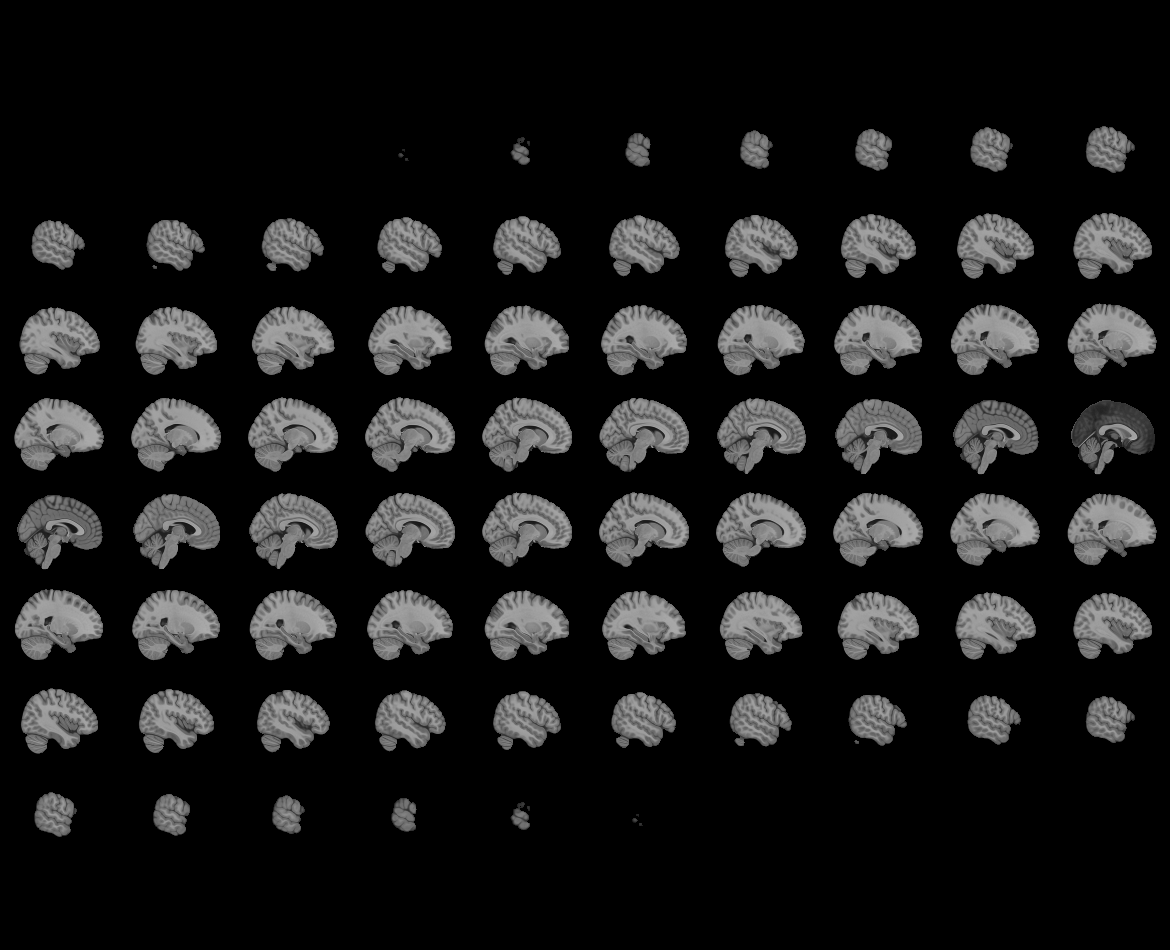
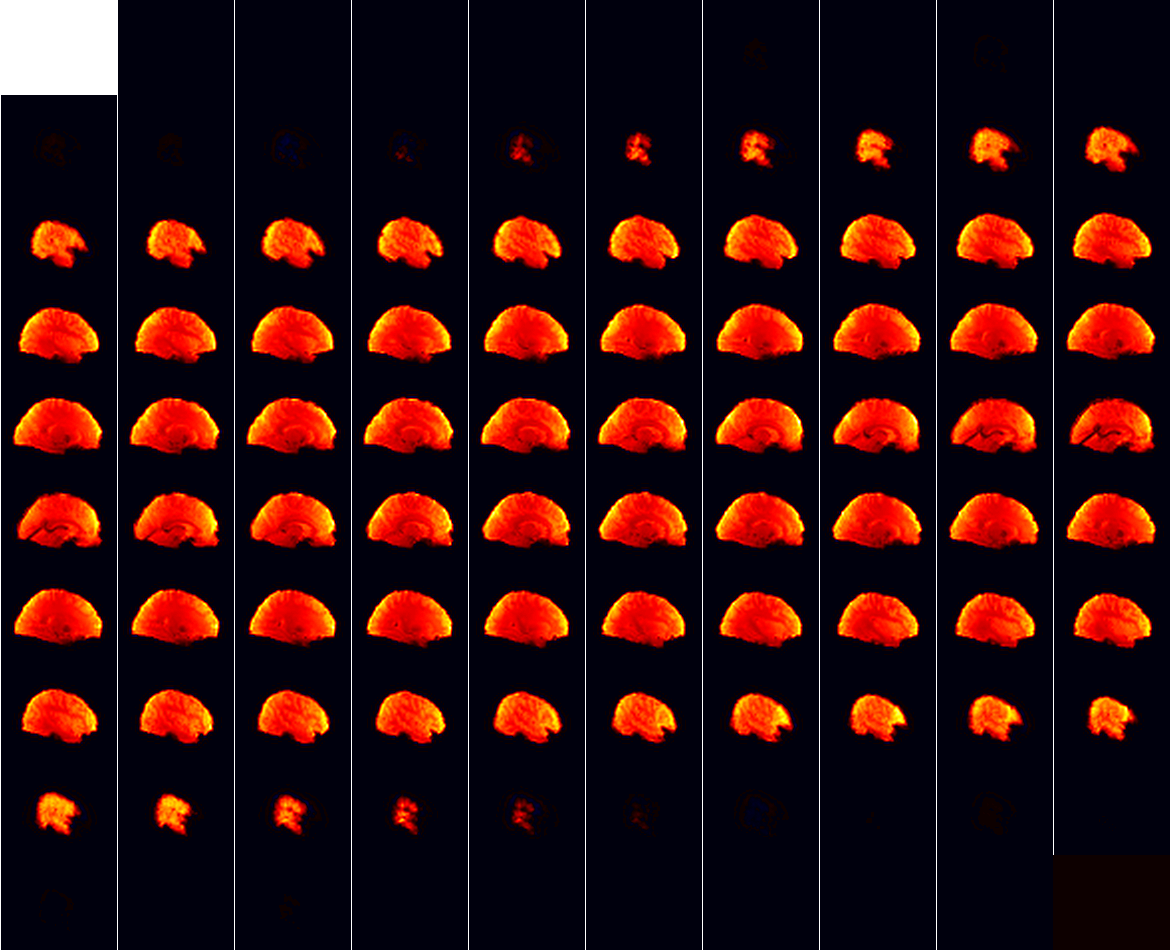

In [7]:
plotting.view_img(image.mean_img(func_file), threshold=None)

Now we'll import a package from <code>nilearn</code>, called <code>input_data</code> which allows us to extract the time series data using the parcellation file (i.e., the average signal over time from each of the regions of the parcellations will be extracted), and at the same time applying data preprocessing to clean the time series!

We first create an object using the parcellation file <code>Harvard-Oxford atlas</code> and our cleaning settings which are the following:

Settings to use:
- Confounds: trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, white_matter, csf, global_signal
- Temporal Derivatives: Yes
- high_pass = 0.009
- low_pass = 0.08
- detrend = True
- standardize = True

To extract signal on the parcellation you can use the NiftiLabelsMasker in Python. It is a processing object that is created by specifying all the important parameters (e.g, how to preprocess the data), but not the data itself. You have to give the data to the masker later on and you can use it on as many functional imaging data as you want.

In [8]:
# Note: if you are using Nilearn with a version newer than 0.9.0 (e.g., in the future on your local laptop),
#then you should use the following: from nilearn.maskers import NiftiLabelsMasker

from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                      t_r=2
                                    )


The object <code>masker</code> is now able to be used on *any functional image of the same size*. The `input_data.NiftiLabelsMasker` object is a wrapper that applies parcellation, cleaning and averaging to an functional image. For example let's apply this to our first subject:

### Using the masker
Finally with everything set up, we can now use the masker to perform our:
1. Confounds cleaning
2. Parcellation
3. Extract the average time series from one parcel (i.e., one brain region)<p>
All in one step!


In [9]:
#Apply cleaning, parcellation and extraction to functional data
time_series = masker.fit_transform(func_file, confounds=confound_file)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)

[NiftiLabelsMasker.wrapped] Resampling labels

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7ee1602b6e10>,
  'low_pass': 0.08,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, confounds=[ '/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'], sample_mask=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_l

[NiftiLabelsMasker.wrapped] Loading data from 
/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc
_bold.nii.gz

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

_______________________________________________filter_and_extract - 1.7s, 0.0min


Now we can have a look at the time series of one of the regions from the functional data.

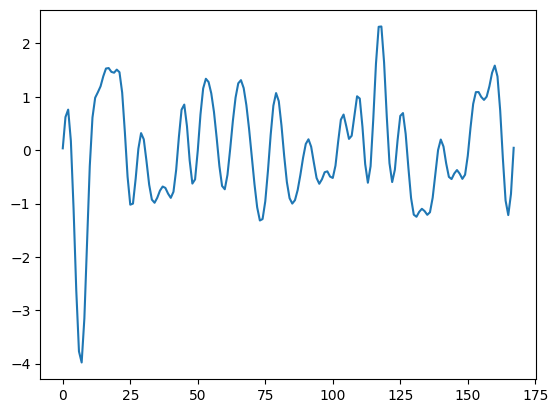

In [31]:
plt.plot(time_series[:,47])
# if you want to look at another region, just change the number 1 to another number in the code!

<div class="alert alert-block alert-success">
<b>Exercise 1</b><p>
Now let's look at the time series structure. What do these two values (168,48) mean?
    
</div>

In [11]:
time_series.shape

(168, 48)

The result of running <code>masker.fit_transform</code> is a matrix that has: <p>
INSERT ANSWER HERE
- Rows matching the time (168)
- Columns matching the ROIs (48)

<div class="alert alert-block alert-success">
-End of Exercise-
            </div>

We originally had **49 ROIs**, what happened to 1 of them? It turns out that <code>masker</code> drops ROIs that are empty (i.e contain no brain voxels inside of them), this means that 1 of our atlas' parcels did not correspond to any region with signal! To see which ROIs are kept after computing a parcellation you can look at the <code>labels_</code> property of <code>masker</code>:

In [33]:
print(masker.labels_)
print("Number of labels", len(masker.labels_))

[np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(28), np.uint8(29), np.uint8(30), np.uint8(31), np.uint8(32), np.uint8(33), np.uint8(34), np.uint8(35), np.uint8(36), np.uint8(37), np.uint8(38), np.uint8(39), np.uint8(40), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(44), np.uint8(45), np.uint8(46), np.uint8(47), np.uint8(48)]
Number of labels 48


If you want to work with multiple subjects (all of whom might have different missing values), you should create an array that contains the all regions (and has zeros for the missing values). This is not part of our class today.

### Calculating Connectivity


We now have 48 time series from 48 regions, so we can see which regions have similar activity over time, i.e., are functionally connected to each other. This does not mean that they are directly connected via fibers, but they can be also connected via another region.

<div class="alert alert-block alert-success">
<b>Exercise 2</b><p>

There are different types of connectivity that we will discuss:
    1. ROI-based connectivity
    2. Independent component analysis.
Please have a look inside this paper: http://www.ajnr.org/content/early/2018/01/18/ajnr.A5527 and explain the difference between these two.
    
    
-End of Exercise-  
</div>

In our seminar today, we will focus on the ROI-based connectivity, i.e. we will see how each region (of interest = ROI) from a parcellation is functionally connected with each other. We will calculate a *full connectivity matrix* by computing the correlation between *all pairs of ROIs* in our parcellation scheme!

We'll use another nilearn tool called <code>ConnectivityMeasure</code> from <code>nilearn.connectome</code>. This tool will perform the full set of pairwise correlations for us

Like the masker, we need to make an object that will calculate connectivity for us.

In [34]:
from nilearn.connectome import ConnectivityMeasure

In [35]:
correlation_measure = ConnectivityMeasure(kind='correlation')

Then we use <code>correlation_measure.fit_transform()</code> in order to calculate the full correlation matrix for our parcellated data!


<div class="alert alert-block alert-success">
<b>Exercise 3</b><p>

Please now include the missing variable (i.e., the preprocessed time series from above) in the code below to calculate the connectivity.

</div>

In [40]:
full_correlation_matrix = correlation_measure.fit_transform([time_series])

In [44]:
full_correlation_matrix

array([[[ 1.        ,  0.28616726,  0.50101324, ...,  0.18254835,
         -0.12982293,  0.39243756],
        [ 0.28616726,  1.        ,  0.21921864, ...,  0.39117252,
          0.03213952,  0.36249005],
        [ 0.50101324,  0.21921864,  1.        , ..., -0.00251108,
         -0.29306892,  0.1452311 ],
        ...,
        [ 0.18254835,  0.39117252, -0.00251108, ...,  1.        ,
          0.19780587,  0.1228828 ],
        [-0.12982293,  0.03213952, -0.29306892, ...,  0.19780587,
          1.        ,  0.18569799],
        [ 0.39243756,  0.36249005,  0.1452311 , ...,  0.1228828 ,
          0.18569799,  1.        ]]])

<div class="alert alert-block alert-success">
-End of Exercise-  
</div>

<div class="alert alert-block alert-success">
<b>Exercise 3a (optional)</b><p>

If you have time, how can you calcuate functional connectivity without a Nilearn function (i.e., just the correlations of the time series)? E.g., which Numpy or scikit-learn functions would be suitable to retrieve pairwise correlations or even ICA?

</div>

In [ ]:
import sklearn

<div class="alert alert-block alert-success">
-End of Exercise-  
</div>

<div class="alert alert-block alert-success">
<b>Exercise 4</b><p>
Let's now look at the shape of the resulting connectivity matrix. What does it mean?
    
INSERT ANSWER HERE

In [42]:
full_correlation_matrix.shape

(1, 48, 48)

<div class="alert alert-block alert-success">
-End of Exercise-  
</div>

<div class="alert alert-block alert-success">
<b>Exercise 5</b><p>

Below you find a visualization of the connectivity matrix. How would you describe it?
    
Symmetrical, full connectivity of regions with themselves
</div>

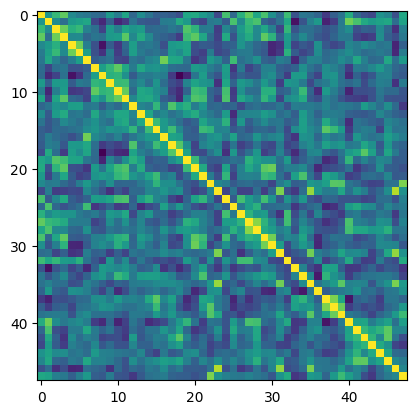

In [43]:
plt.imshow(np.squeeze(full_correlation_matrix))

<div class="alert alert-block alert-success">
-End of Exercise-  
</div>

<div class="alert alert-block alert-success">
<b>Exercise 6</b><p>

Now that you know functional connectivity. It gives a value for each pair of brain regions over time. Can you split your team into two and one half does a search on  dynamic functional connectivity and the other on effective connectivity and then explains to the others? What are its advantages and disadvantages?
    


*   dyn. func. connectivity:
*   effective connectivity: implication of activity between regions



-End of Exercise-  
</div>

## Congratulations!

Hopefully now you understand that:

1. fMRI data needs to be pre-processed before analyzing
2. Manipulating images in python is easily done using `nilearn` and `nibabel`
3. You can also do post-processing like confound/nuisance regression using `nilearn`
4. Parcellating is a method of simplifying and "averaging" data. The type of parcellation reflect assumptions you make about the structure of your data
5. Functional Connectivity is really just time-series correlations between two signals!

## More information/additional reading material:

https://andysbrainbook.readthedocs.io/en/latest/

https://nilearn.github.io/user_guide.html